In [31]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import glob
import datetime
import seaborn as sns
import pickle
import random

from shapely.geometry import Point
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,median_absolute_error,max_error
from scipy.interpolate import LinearNDInterpolator, interp2d, BivariateSpline
from scipy.stats import skew
from collections import Counter

In [2]:
import WNN

Using TensorFlow backend.


In [3]:
import importlib
importlib.reload(WNN)

<module 'WNN' from 'C:\\Users\\students\\Desktop\\wrf_ml\\WNN.py'>

In [4]:
from WNN import WindNeuralNetwork,prepare_new_data,add_daymonth_and_sort

In [5]:
def get_stats(df,t_name='Power',p_name='Predicted_Power'):
    return {'R2':r2_score(df[t_name].values,df[p_name].values),
           'MAE' : mean_absolute_error(df[t_name].values,df[p_name].values),
           'RMSE' : np.sqrt(mean_squared_error(df[t_name].values,df[p_name].values)),
           'MedAE' : median_absolute_error(df[t_name].values,df[p_name].values),
           'ME' : max_error(df[t_name].values,df[p_name].values)}

def extract_months(dict_of_df,months,timename= 'Date-time'):
    output = {}
    for i in dict_of_df:
        output[i] = dict_of_df[i][dict_of_df[i][timename].apply(lambda x: x.month in months)]
    return output

### Load WRF Data

In [6]:
wt_list=['WTG01','WTG02','WTG03','WTG04','WTG05','WTG06','WTG07','WTG08','WTG09',
         'WTG10','WTG11','WTG12','WTG13','WTG14','WTG15','WTG16']
nominal_power = dict(zip(wt_list, 4*[2000]+4*[3300]+8*[2000]))

In [7]:
with open('wt_95_final.pickle', 'rb') as handle:
    df_95 = pickle.load(handle)
with open('wt_150_final.pickle', 'rb') as handle:
    df_150 = pickle.load(handle)

In [8]:
df_95['WTG01'].head()

Date-time                  Ws                Wdir  \
0 2019-06-10 09:00:00  3.8213380406315958  234.24475442920442   
0 2019-06-10 09:10:00   3.032147542820379  232.71074333452984   
0 2019-06-10 09:20:00  2.8881561225174286   235.8476647282395   
0 2019-06-10 09:30:00  2.8783832295518175   244.4965577468874   
0 2019-06-10 09:40:00  2.4958418099088826   249.4015346677861   

                    T                  P  
0   294.3506448437005  883.2411974960578  
0   294.9718062208258  884.1391936560981  
0  295.28616917647224  883.5835334906673  
0   295.5124789942895  883.0259440947316  
0   295.7229402529741   883.014433375523

In [9]:
for i in df_95:
    df_95[i]=add_daymonth_and_sort(df_95[i]).reset_index(drop=True)
for i in df_150:
    df_150[i]=add_daymonth_and_sort(df_150[i]).reset_index(drop=True)

### Load Juvent Data

In [10]:
df_juvent = pd.read_csv('Juvent_Data_2019_2020.csv')
df_juvent['Time'] = pd.to_datetime(df_juvent['Time'])

C:\Users\students\Anaconda3\envs\wnn\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
df_juvent.head()

Time  Turbine_id  Production  Power  Wind_Speed  \
0 2020-07-24 09:40:00          15      1027.0  248.0        20.0   
1 2020-07-24 09:40:00           9      1101.0  140.0        17.0   
2 2020-07-24 09:40:00          16      1554.0  391.0        23.0   
3 2020-07-24 09:40:00           8      1040.0  140.0        15.0   
4 2020-07-24 09:40:00           1      1043.0  210.0        18.0   

  Wind_Direction  Temperature  
0              W         16.0  
1              W         16.0  
2              W         16.0  
3              W         18.0  
4              W         16.0

### Merge both datasets for given chosen months

In [12]:
wt_95_all, wt_150_all = {},{}
for i,wt in enumerate(df_95,start = 1):
    wt_95_all[wt] = pd.merge(df_95[wt],df_juvent[df_juvent.Turbine_id == i],
                    left_on = 'Date-time',
                    right_on = 'Time',).drop(['Turbine_id','Time'],axis = 1)
    wt_150_all[wt] = pd.merge(df_150[wt],df_juvent[df_juvent.Turbine_id == i],
                    left_on = 'Date-time',
                    right_on = 'Time',).drop(['Turbine_id','Time'],axis = 1)

In [13]:
wt_95_all[wt].head()

Date-time                 Ws                Wdir  \
0 2020-07-21 03:00:00    7.7589005306996  231.83912426131985   
1 2020-07-21 02:50:00  7.598729550372616  240.18902340807702   
2 2020-07-21 02:40:00   7.40161960851656  243.12351195003802   
3 2020-07-21 02:30:00  7.402729518249467  233.97941327170452   
4 2020-07-21 02:20:00  7.331699875326263  232.08396184121005   

                    T                  P Day_Month  Production  Power  \
0  301.96936459198446  889.4287285775886      21_7       -20.0    0.0   
1  301.98190296387713   889.433225444358      21_7       -20.0    0.0   
2  302.04241602726916   889.391755139078      21_7       -20.0  -28.0   
3   302.1580337233968  889.3791196110772      21_7       -15.0    0.0   
4   302.4039500330704  889.4311508587598      21_7       -15.0    0.0   

   Wind_Speed Wind_Direction  Temperature  
0        11.0             SO         20.0  
1         9.0              O         19.0  
2         8.0             SO         19.0  
3         8.0             SO         20.0  
4         8.0             SO         19.0

### Remove days with less than 50 measurements (heavily incomplete days)

In [15]:
for wt in wt_list:
    tmp = Counter(wt_95_all[wt].Day_Month)
    ic_day = [i for i,j in zip(tmp.keys(),tmp.values()) if j < 50]
    wt_95_all[wt] = wt_95_all[wt][wt_95_all[wt].Day_Month.apply(lambda x : x not in ic_day)]
    wt_150_all[wt] = wt_150_all[wt][wt_150_all[wt].Day_Month.apply(lambda x : x not in ic_day)]
    print(len(ic_day))

11
2
4
6
5
8
3
10
4
4
7
3
6
6
5
9


### The outlier problem in  wind speed-power curves
many power values at 0 or extremly low even at high wind speeds

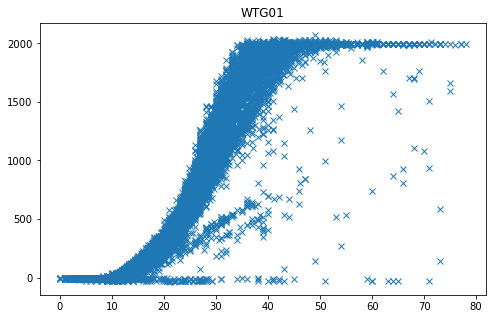

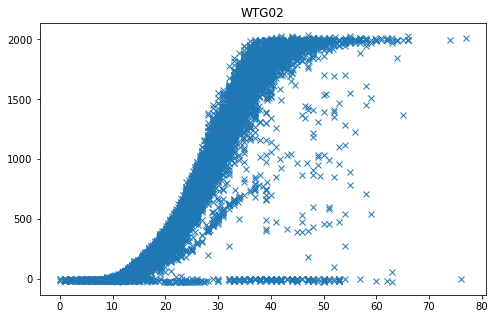

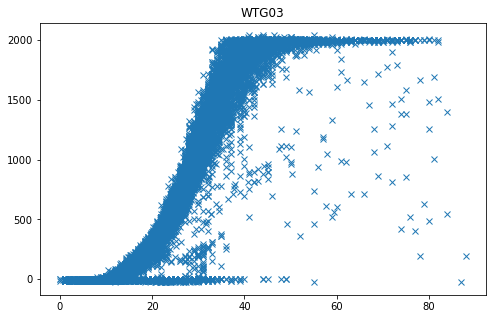

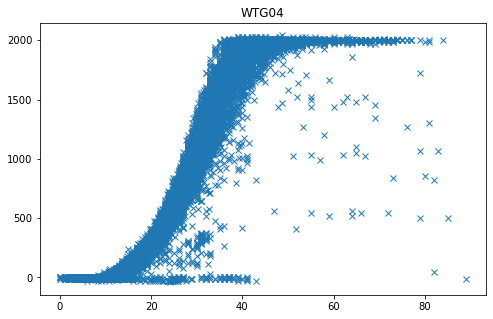

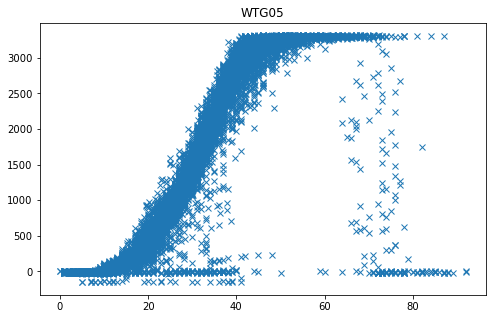

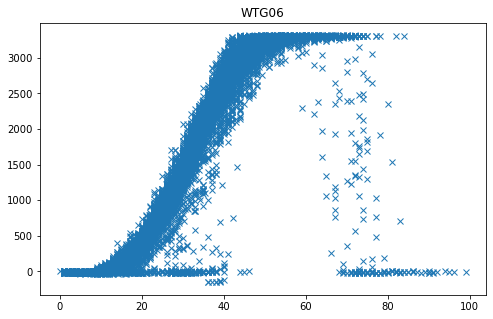

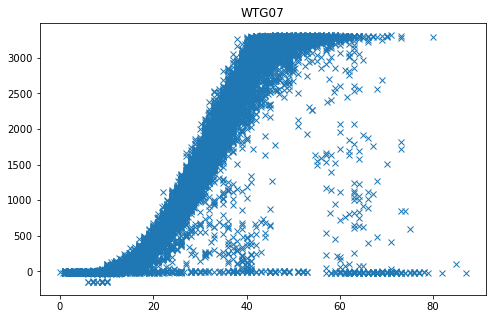

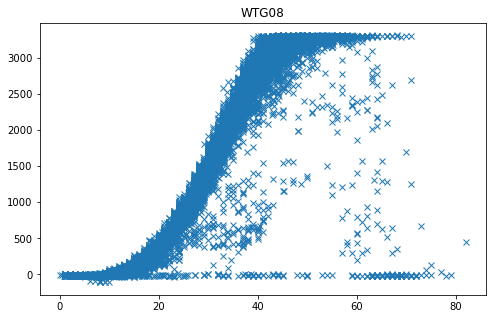

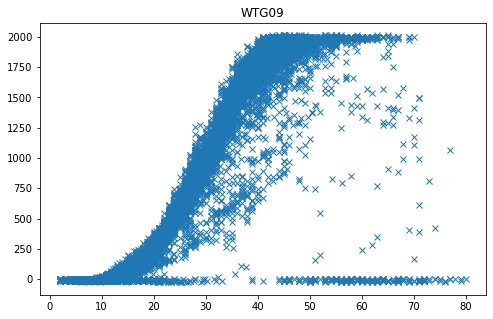

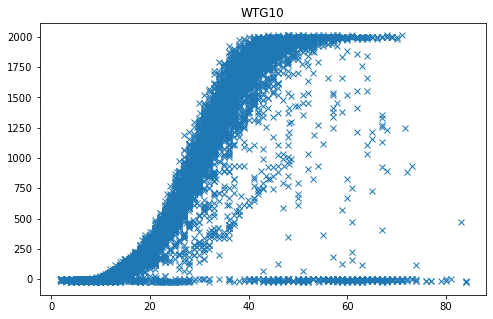

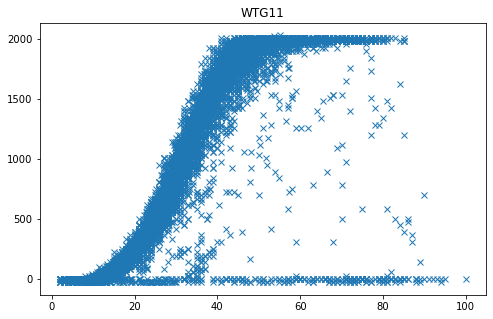

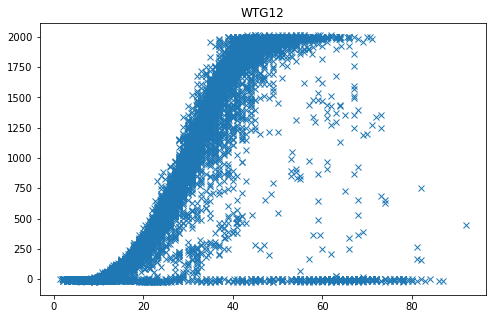

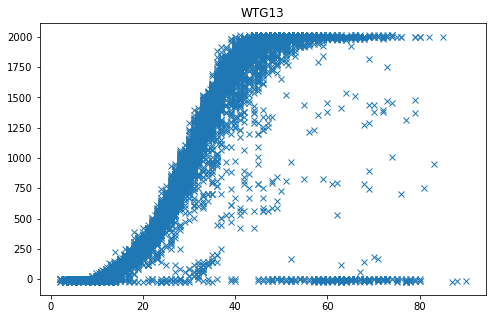

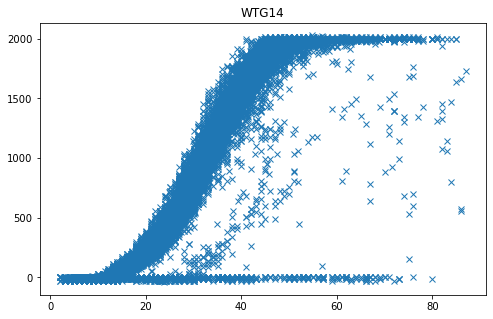

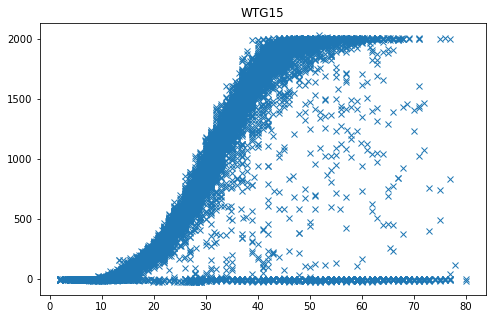

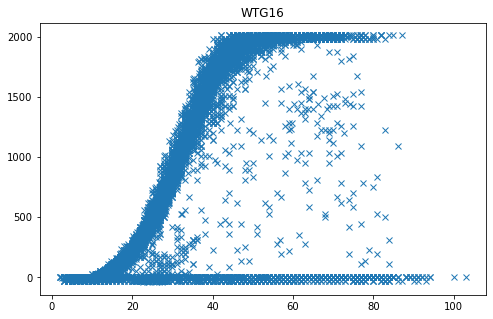

In [16]:
for wt in wt_list:
    fig,ax = plt.subplots(figsize=(8,5))
    plt.plot(wt_95_all[wt].Wind_Speed.values,wt_95_all[wt].Power.values,'x')
    plt.title(wt)
    plt.show()

### lets fit a curve to eliminate erroneous values

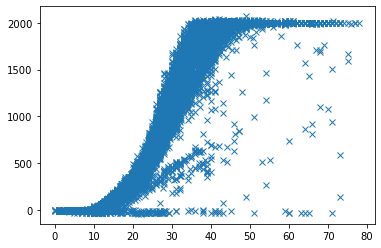

In [17]:
df_aux = wt_95_all['WTG01'].copy()
plt.plot(df_aux.Wind_Speed.values,df_aux.Power.values,'x')

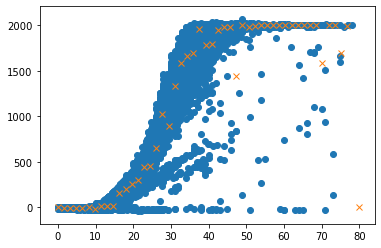

In [18]:
# Interpolation, works but not great. 
df_aux = df_aux.sort_values(by='Wind_Speed')
p_interp = np.interp(np.linspace(0,80),df_aux['Wind_Speed'].values,df_aux['Power'].values)
plt.plot(np.linspace(0,80),p_interp,'xC1')
plt.scatter(df_aux['Wind_Speed'].values,df_aux['Power'].values)

In [19]:
from operational_analysis.toolkits.power_curve.functions import logistic_5_parametric,gam,IEC

In [20]:
df_aux = df_aux.dropna()

In [21]:
lpc = logistic_5_parametric(df_aux['Wind_Speed'],df_aux['Power'])
gpc = gam(df_aux['Wind_Speed'],df_aux['Power'],n_splines=15)
iec = IEC(df_aux['Wind_Speed'],df_aux['Power'],windspeed_end=90.0)

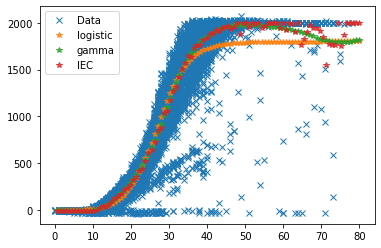

In [22]:
ws_xx = np.linspace(0.5,80,num = 100)

plt.plot(df_aux['Wind_Speed'].values,df_aux['Power'].values,'x',label = 'Data')
plt.plot(ws_xx,lpc(ws_xx),'*',alpha = 0.8,label = 'logistic')
plt.plot(ws_xx,gpc(ws_xx),'*',alpha = 0.8,label = 'gamma')
plt.plot(ws_xx,iec(ws_xx),'*',alpha = 0.8,label = 'IEC')
plt.legend()
plt.show()

In [23]:
## now lets stablish an outlier detection method
def wind_outlier(f,ws,power,w_start = 0.01, w_end = 80, p_start = 0, p_end = 2000,num = 50, alpha = 0.15):
    """
    return 0 if outlier
           1 if not 
    """
    
    ws_xx = np.linspace(w_start,w_end,num)
    p_yy = f(ws_xx)/p_end
    ws_xx = ws_xx/w_end
    outlier = []
    for a,b in zip(ws,power):
        min_dist = np.inf
        for i,j in zip(ws_xx,p_yy):
            tmp = np.sqrt((i-a/w_end)**2 + (j-b/p_end)**2)
            if min_dist > tmp:
                min_dist = tmp
        if min_dist < alpha:
            outlier.append(1)
        else:
            outlier.append(0)
    return outlier

In [24]:
outliers = wind_outlier(lpc,df_aux['Wind_Speed'].values,df_aux['Power'].values,alpha = 0.2)

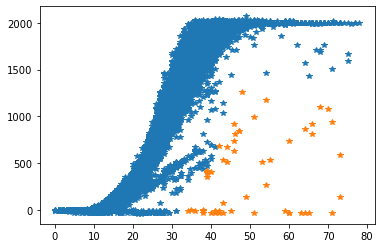

In [25]:
plt.plot(df_aux[np.array(outliers,dtype=bool)].Wind_Speed.values,df_aux[np.array(outliers,dtype=bool)].Power.values,'*')
plt.plot(df_aux[~np.array(outliers,dtype=bool)].Wind_Speed.values,df_aux[~np.array(outliers,dtype=bool)].Power.values,'*')

### Outlier detection looks good now
we can apply it to the entire dataset, we use a two stage outlier detection

In [27]:
nominal_power[wt]

2000

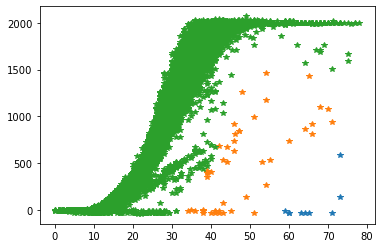

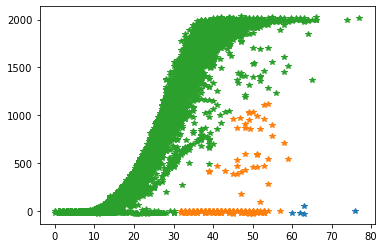

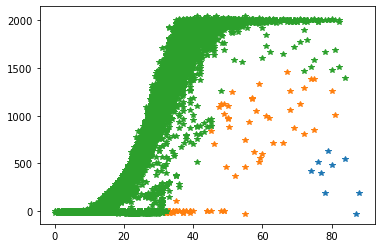

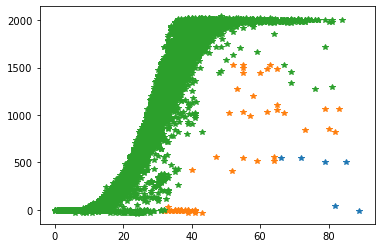

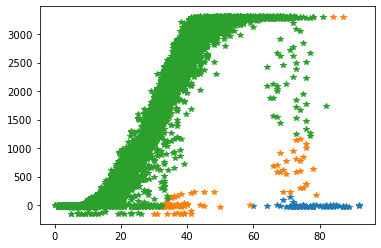

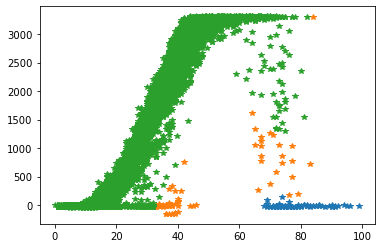

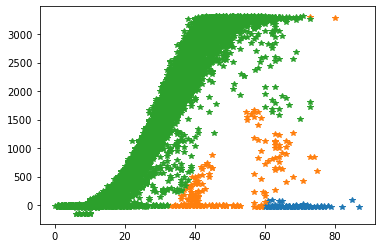

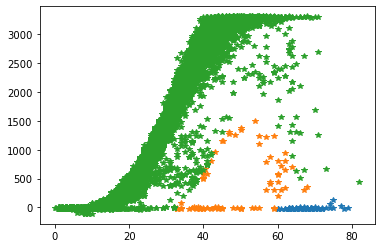

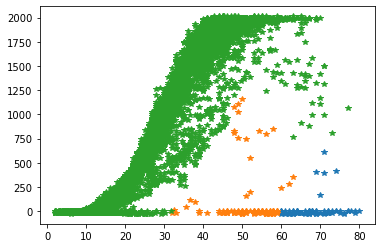

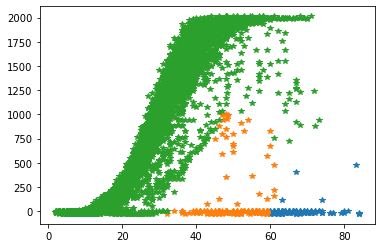

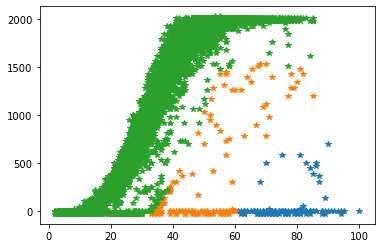

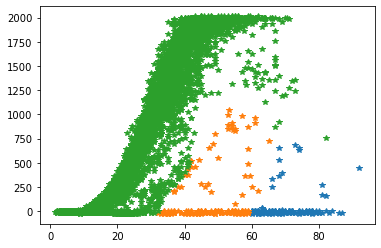

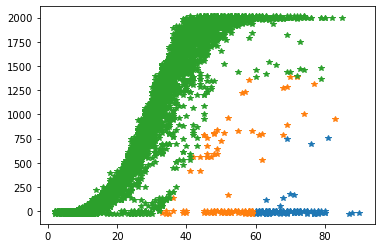

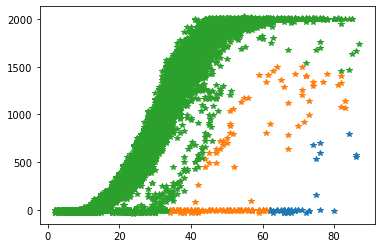

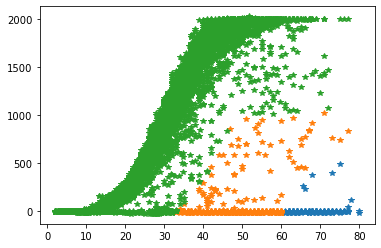

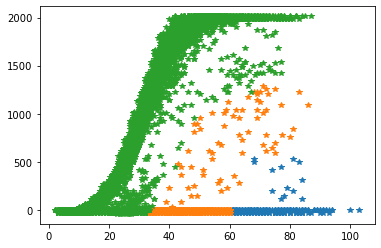

In [28]:
wt_95_all_filtered,wt_150_all_filtered = {},{}
for wt in wt_list:
    
    fig,ax = plt.subplots(figsize=(6,4))
    df_aux = wt_95_all[wt].dropna()
    df_aux2 = wt_150_all[wt].dropna()

    gpc = logistic_5_parametric(df_aux['Wind_Speed'],df_aux['Power'])
    outliers = wind_outlier(gpc,df_aux['Wind_Speed'].values,df_aux['Power'].values,
                            p_end = nominal_power[wt],alpha = 0.5)

    plt.plot(df_aux[~np.array(outliers,dtype=bool)].Wind_Speed.values,
             df_aux[~np.array(outliers,dtype=bool)].Power.values,'*')

    df_aux = df_aux[np.array(outliers,dtype=bool)]
    df_aux2 = df_aux2[np.array(outliers,dtype=bool)]
    
    gpc = gam(df_aux['Wind_Speed'],df_aux['Power'])
    outliers = wind_outlier(gpc,df_aux['Wind_Speed'].values,df_aux['Power'].values,
                            p_end = nominal_power[wt],alpha = 0.2)

    plt.plot(df_aux[~np.array(outliers,dtype=bool)].Wind_Speed.values,
             df_aux[~np.array(outliers,dtype=bool)].Power.values,'*')

    df_aux = df_aux[np.array(outliers,dtype=bool)]
    df_aux2 = df_aux2[np.array(outliers,dtype=bool)]    
    
    
    plt.plot(df_aux.Wind_Speed.values,df_aux.Power.values,'*')
    
    wt_95_all_filtered[wt] = df_aux
    wt_150_all_filtered[wt] = df_aux2
    plt.show()

In [29]:
for wt in wt_list: # again remove incomplete days due to outlier deletion
    tmp = Counter(wt_95_all_filtered[wt].Day_Month)
    ic_day = [i for i,j in zip(tmp.keys(),tmp.values()) if j < 50]
    wt_95_all_filtered[wt] = wt_95_all_filtered[wt][wt_95_all_filtered[wt].Day_Month.apply(lambda x : x not in ic_day)]
    wt_150_all_filtered[wt] = wt_150_all_filtered[wt][wt_150_all_filtered[wt].Day_Month.apply(lambda x : x not in ic_day)]
    print(len(ic_day))

0
0
0
0
0
0
0
1
0
2
1
1
1
0
2
8


### Now that the data is in order, we can fit the forecast model
First we extract a validation set from the data, four entire days per month selected randomly. the remaning data will be split into training and testing set by the NN, we dont have to do that manually.

In [88]:
month_days_dict = {}
month_days_test = []
for m in range(1,13):
    month_days_dict[m] = []
    for s in wt_95_all_filtered['WTG01'].Day_Month.unique():
        if int(s.split('_')[1]) == m:
            month_days_dict[m].append(s.split('_')[0])
    for i in random.sample(range(0, len(month_days_dict[m])), 4):
        month_days_test.append(str(m)+'_'+str(month_days_dict[m][i]))

In [105]:
#save the desired run so that we can reproduce the results
month_days_test =['1_5','1_9','1_10','1_19','2_5','2_3','2_18','2_4','3_26','3_18','3_21','3_13','4_23','4_7',
 '4_21','4_4','5_14','5_20','5_24','5_17','6_21','6_2','6_16','6_18','7_26','7_16','7_21','7_19','8_24','8_6',
 '8_4','8_5','9_10','9_7','9_20','9_13','10_24','10_5','10_4','10_13','11_28','11_25','11_7','11_10','12_3',
 '12_16','12_21','12_1']

In [89]:
#split the data
wt_95_retrain, wt_95_test,wt_150_retrain, wt_150_test = {},{},{},{}
for wt in wt_list:
    wt_95_retrain[wt]  = wt_95_all_filtered[wt][wt_95_all_filtered[wt].Day_Month.apply(lambda x: x not in month_days_test)]
    wt_95_test[wt]     = wt_95_all_filtered[wt][wt_95_all_filtered[wt].Day_Month.apply(lambda x: x in month_days_test)]
    wt_150_retrain[wt] = wt_150_all_filtered[wt][wt_95_all_filtered[wt].Day_Month.apply(lambda x: x not in month_days_test)]
    wt_150_test[wt]    = wt_150_all_filtered[wt][wt_95_all_filtered[wt].Day_Month.apply(lambda x: x in month_days_test)]

#### Now we can train the NN with the desired parameters

In [90]:
wnn_dict = {}
all_stats = {}
for wt in wt_list:
    print('----------------------')
    print('------  '+wt+'  ------')
    print('----------------------')
    wnn = WNN.WindNeuralNetwork(wt_95_retrain[wt],wt_150_retrain[wt],var = 'Power',
                                features=['Ws', 'Wdir', 'T','P'],
                                look_back=9,
                                time_jump=1,
                                q_weight=1.5,
                                quantile=0.55,
                                include_tanh = True,
                                patience = 3,
                                epochs = 45,
                                scaler = 'Standard') #Initialize it with the loaded data
    wnn.prep_data()#Prepare the data
    wnn.create_and_fit_model(verbose = 1)  # Create and fit the model  you can set verbose to 1 to see the training evolution
    wnn.predict_and_getmetrics_test()
    print(wnn.stats)
    all_stats[wt] = wnn.stats
    wnn_dict[wt] = wnn

----------------------
------  WTG01  ------
----------------------
Train on 26259 samples, validate on 4635 samples
Epoch 1/45
26259/26259 [==============================] - 1s 41us/step - loss: 0.3541 - val_loss: 0.3175
Epoch 2/45
26259/26259 [==============================] - 1s 35us/step - loss: 0.3255 - val_loss: 0.3124
Epoch 3/45
26259/26259 [==============================] - 1s 35us/step - loss: 0.3119 - val_loss: 0.3045
Epoch 4/45
26259/26259 [==============================] - 1s 35us/step - loss: 0.3031 - val_loss: 0.2887
Epoch 5/45
26259/26259 [==============================] - 1s 35us/step - loss: 0.2934 - val_loss: 0.2804
Epoch 6/45
26259/26259 [==============================] - 1s 35us/step - loss: 0.2891 - val_loss: 0.2880
Epoch 7/45
26259/26259 [==============================] - 1s 34us/step - loss: 0.2831 - val_loss: 0.2799
Epoch 8/45
26259/26259 [==============================] - 1s 35us/step - loss: 0.2753 - val_loss: 0.2774
Epoch 9/45
26259/26259 [===================

Train on 26400 samples, validate on 4659 samples
Epoch 1/45
26400/26400 [==============================] - 1s 44us/step - loss: 0.3529 - val_loss: 0.3259
Epoch 2/45
26400/26400 [==============================] - 1s 38us/step - loss: 0.3177 - val_loss: 0.3156
Epoch 3/45
26400/26400 [==============================] - 1s 38us/step - loss: 0.3073 - val_loss: 0.3204
Epoch 4/45
26400/26400 [==============================] - 1s 38us/step - loss: 0.3004 - val_loss: 0.3115
Epoch 5/45
26400/26400 [==============================] - 1s 38us/step - loss: 0.2928 - val_loss: 0.2995
Epoch 6/45
26400/26400 [==============================] - 1s 38us/step - loss: 0.2865 - val_loss: 0.2882
Epoch 7/45
26400/26400 [==============================] - 1s 38us/step - loss: 0.2812 - val_loss: 0.2837
Epoch 8/45
26400/26400 [==============================] - 1s 38us/step - loss: 0.2726 - val_loss: 0.2780
Epoch 9/45
26400/26400 [==============================] - 1s 38us/step - loss: 0.2677 - val_loss: 0.2743
Epoch 

26202/26202 [==============================] - 1s 39us/step - loss: 0.2121 - val_loss: 0.2216
Epoch 28/45
26202/26202 [==============================] - 1s 39us/step - loss: 0.2084 - val_loss: 0.2057
Epoch 29/45
26202/26202 [==============================] - 1s 39us/step - loss: 0.2092 - val_loss: 0.2269
Epoch 30/45
26202/26202 [==============================] - 1s 39us/step - loss: 0.2037 - val_loss: 0.2194
Epoch 31/45
26202/26202 [==============================] - 1s 39us/step - loss: 0.2045 - val_loss: 0.2130
[0.8478947424306496, 285.2149727557627, 168625.29809659987, 194.70893977311903, 3119.747088105315]
----------------------
------  WTG08  ------
----------------------
Train on 26202 samples, validate on 4625 samples
Epoch 1/45
26202/26202 [==============================] - 1s 45us/step - loss: 0.4054 - val_loss: 0.3544
Epoch 2/45
26202/26202 [==============================] - 1s 38us/step - loss: 0.3694 - val_loss: 0.3395
Epoch 3/45
26202/26202 [==============================] 

26299/26299 [==============================] - 1s 38us/step - loss: 0.3035 - val_loss: 0.2993
Epoch 12/45
26299/26299 [==============================] - 1s 37us/step - loss: 0.2986 - val_loss: 0.2956
Epoch 13/45
26299/26299 [==============================] - 1s 38us/step - loss: 0.2930 - val_loss: 0.3189
Epoch 14/45
26299/26299 [==============================] - 1s 38us/step - loss: 0.2870 - val_loss: 0.2924
Epoch 15/45
26299/26299 [==============================] - 1s 38us/step - loss: 0.2790 - val_loss: 0.2887
Epoch 16/45
26299/26299 [==============================] - 1s 38us/step - loss: 0.2790 - val_loss: 0.2768
Epoch 17/45
26299/26299 [==============================] - 1s 38us/step - loss: 0.2712 - val_loss: 0.2840
Epoch 18/45
26299/26299 [==============================] - 1s 38us/step - loss: 0.2712 - val_loss: 0.2834
Epoch 19/45
26299/26299 [==============================] - 1s 37us/step - loss: 0.2646 - val_loss: 0.2735
Epoch 20/45
26299/26299 [==============================] -

[0.7766605408811238, 203.2695595334271, 88342.49091835537, 129.6114416690997, 1896.6964260026486]
----------------------
------  WTG14  ------
----------------------
Train on 26173 samples, validate on 4619 samples
Epoch 1/45
26173/26173 [==============================] - 1s 45us/step - loss: 0.4348 - val_loss: 0.3891
Epoch 2/45
26173/26173 [==============================] - 1s 38us/step - loss: 0.3907 - val_loss: 0.3710
Epoch 3/45
26173/26173 [==============================] - 1s 39us/step - loss: 0.3742 - val_loss: 0.3814
Epoch 4/45
26173/26173 [==============================] - 1s 38us/step - loss: 0.3606 - val_loss: 0.3534
Epoch 5/45
26173/26173 [==============================] - 1s 38us/step - loss: 0.3496 - val_loss: 0.3495
Epoch 6/45
26173/26173 [==============================] - 1s 38us/step - loss: 0.3413 - val_loss: 0.3380
Epoch 7/45
26173/26173 [==============================] - 1s 39us/step - loss: 0.3312 - val_loss: 0.3333
Epoch 8/45
26173/26173 [==========================

25176/25176 [==============================] - 1s 38us/step - loss: 0.3595 - val_loss: 0.3592
Epoch 6/45
25176/25176 [==============================] - 1s 38us/step - loss: 0.3484 - val_loss: 0.3448
Epoch 7/45
25176/25176 [==============================] - 1s 37us/step - loss: 0.3442 - val_loss: 0.3338
Epoch 8/45
25176/25176 [==============================] - 1s 37us/step - loss: 0.3389 - val_loss: 0.3328
Epoch 9/45
25176/25176 [==============================] - 1s 37us/step - loss: 0.3338 - val_loss: 0.3271
Epoch 10/45
25176/25176 [==============================] - 1s 37us/step - loss: 0.3306 - val_loss: 0.3309
Epoch 11/45
25176/25176 [==============================] - 1s 37us/step - loss: 0.3213 - val_loss: 0.3400
Epoch 12/45
25176/25176 [==============================] - 1s 37us/step - loss: 0.3167 - val_loss: 0.3217
Epoch 13/45
25176/25176 [==============================] - 1s 37us/step - loss: 0.3119 - val_loss: 0.3073
Epoch 14/45
25176/25176 [==============================] - 1s 

In [220]:
## Save the trained models
#with open('wnn_dict_final.pickle', 'wb') as handle:
#    pickle.dump(wnn_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### use the NN trained above to predict the validation set

------  WTG01  ------
MAE = 12.53
RMSE = 17.79
MedAE = 8.34
ME = 87.73


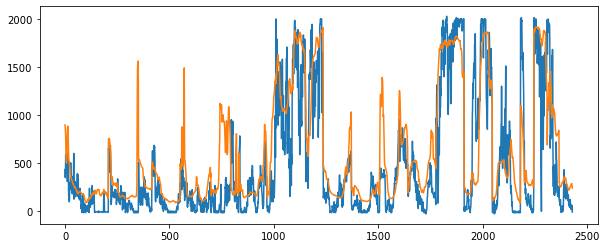

------  WTG02  ------
MAE = 9.86
RMSE = 14.36
MedAE = 6.18
ME = 63.67


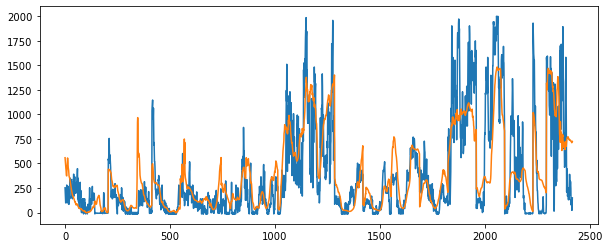

------  WTG03  ------
MAE = 10.88
RMSE = 16.45
MedAE = 6.53
ME = 89.38


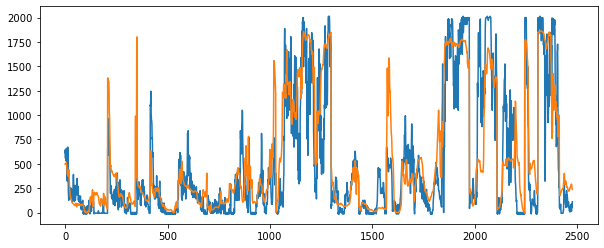

------  WTG04  ------
MAE = 12.59
RMSE = 18.69
MedAE = 7.75
ME = 70.16


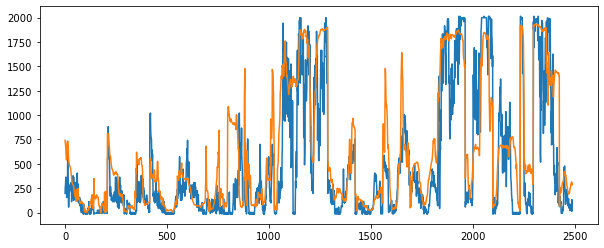

------  WTG05  ------
MAE = 12.92
RMSE = 20.25
MedAE = 6.99
ME = 86.28


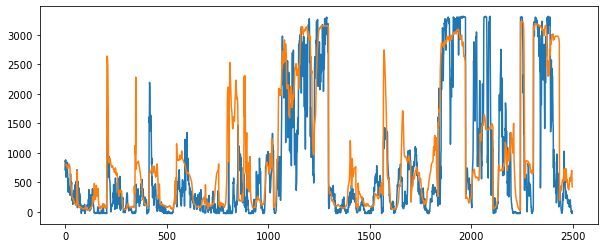

------  WTG06  ------
MAE = 11.4
RMSE = 17.24
MedAE = 6.85
ME = 84.72


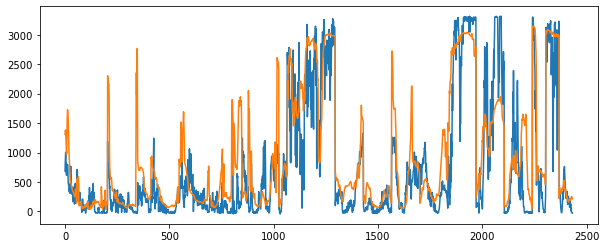

------  WTG07  ------
MAE = 11.51
RMSE = 17.17
MedAE = 7.49
ME = 77.97


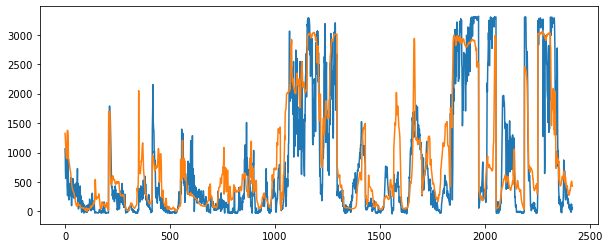

------  WTG08  ------
MAE = 11.34
RMSE = 17.02
MedAE = 6.83
ME = 82.52


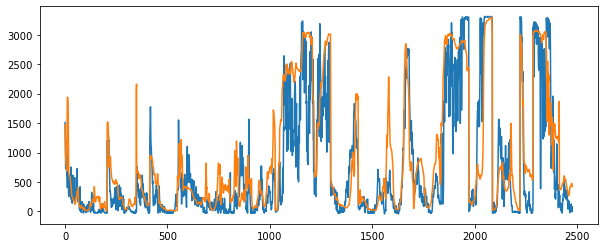

------  WTG09  ------
MAE = 10.51
RMSE = 15.81
MedAE = 6.88
ME = 80.61


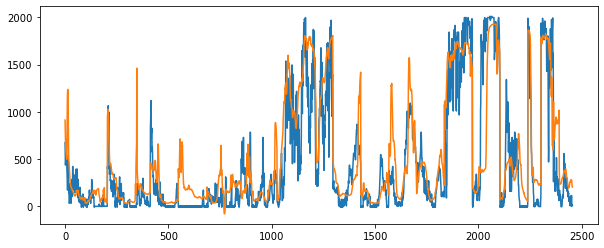

------  WTG10  ------
MAE = 11.13
RMSE = 16.6
MedAE = 6.18
ME = 80.02


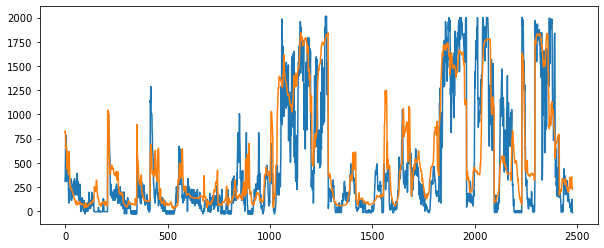

------  WTG11  ------
MAE = 11.85
RMSE = 17.8
MedAE = 6.9
ME = 86.03


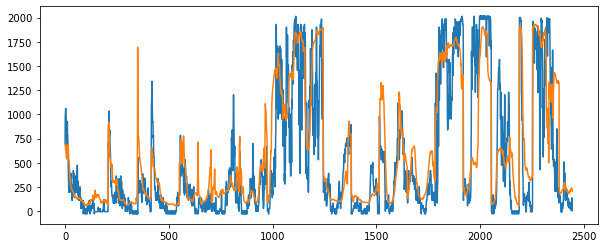

------  WTG12  ------
MAE = 11.52
RMSE = 17.98
MedAE = 6.65
ME = 87.47


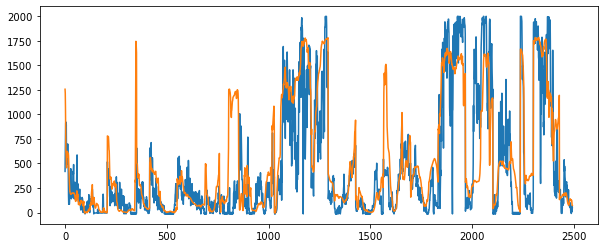

------  WTG13  ------
MAE = 11.95
RMSE = 18.2
MedAE = 7.08
ME = 102.06


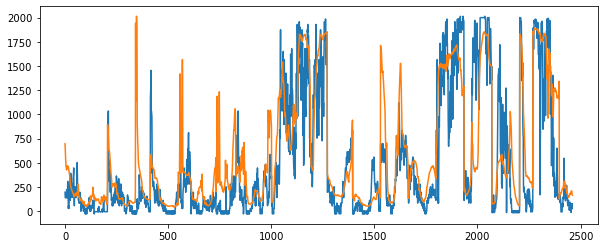

------  WTG14  ------
MAE = 12.21
RMSE = 18.34
MedAE = 7.33
ME = 82.77


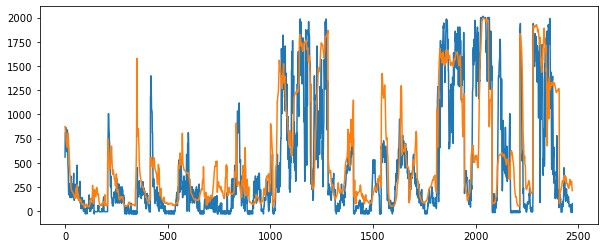

------  WTG15  ------
MAE = 12.08
RMSE = 18.78
MedAE = 6.76
ME = 80.51


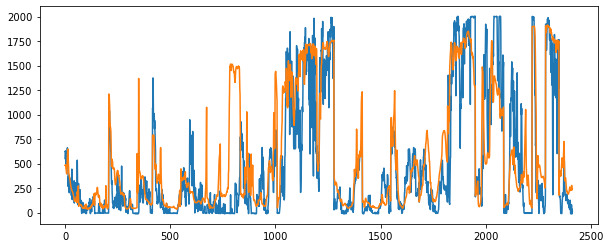

------  WTG16  ------
MAE = 12.27
RMSE = 18.69
MedAE = 6.86
ME = 74.88


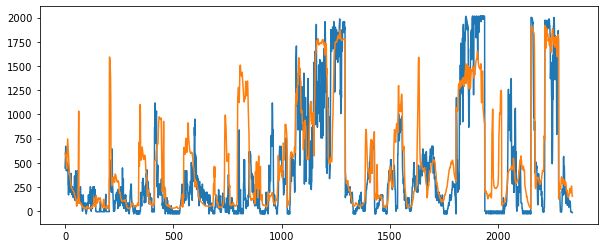

In [91]:
val_stats={}
for wt in wt_list:
    print('------  '+wt+'  ------')
    dfout = wnn_dict[wt].predict_new_data(wt_95_test[wt],wt_150_test[wt])
    stats = get_stats(dfout)
    val_stats[wt] = [stats['R2']]
    for i in list(stats.keys())[1:]:
        val_stats[wt].append(100*stats[i]/nominal_power[wt])
        print(i +' = '+ str(np.round(val_stats[wt][-1],2)))
        
    fig,ax = plt.subplots(figsize=(10,4))
    plt.plot(dfout.Power.values)
    plt.plot(dfout.Predicted_Power.values)
    plt.show()

------  WTG01  ------
MAE = 12.53
RMSE = 17.79
MedAE = 8.34
ME = 87.73


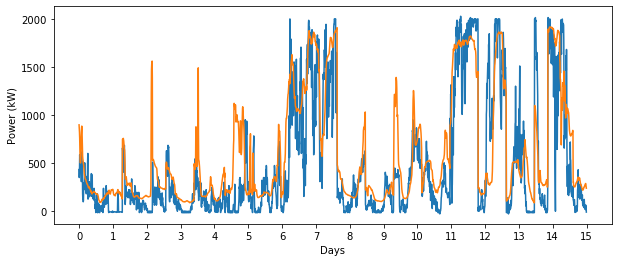

------  WTG02  ------
MAE = 9.86
RMSE = 14.36
MedAE = 6.18
ME = 63.67


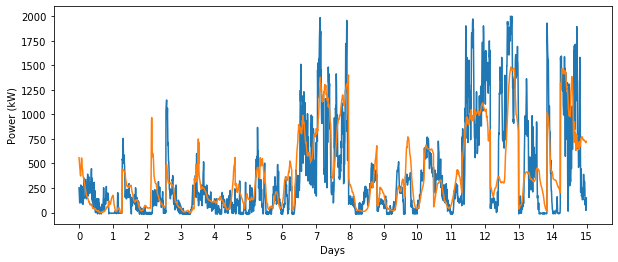

------  WTG03  ------
MAE = 10.88
RMSE = 16.45
MedAE = 6.53
ME = 89.38


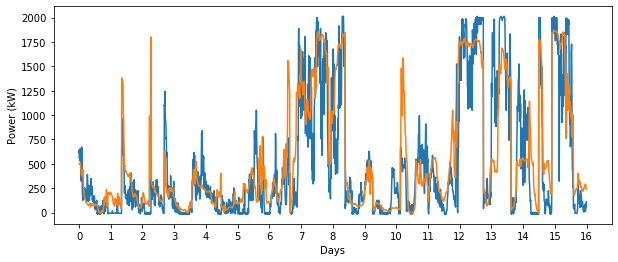

------  WTG04  ------
MAE = 12.59
RMSE = 18.69
MedAE = 7.75
ME = 70.16


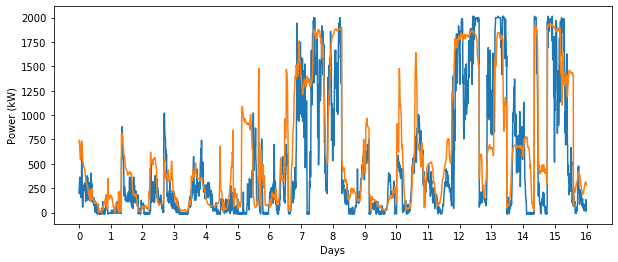

------  WTG05  ------
MAE = 12.92
RMSE = 20.25
MedAE = 6.99
ME = 86.28


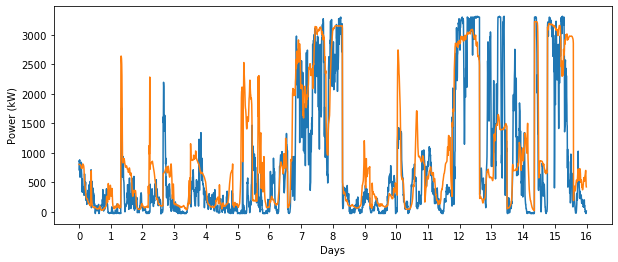

------  WTG06  ------
MAE = 11.4
RMSE = 17.24
MedAE = 6.85
ME = 84.72


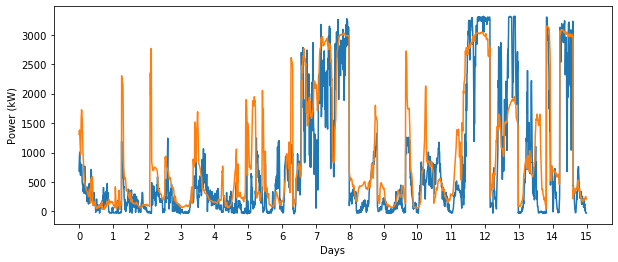

------  WTG07  ------
MAE = 11.51
RMSE = 17.17
MedAE = 7.49
ME = 77.97


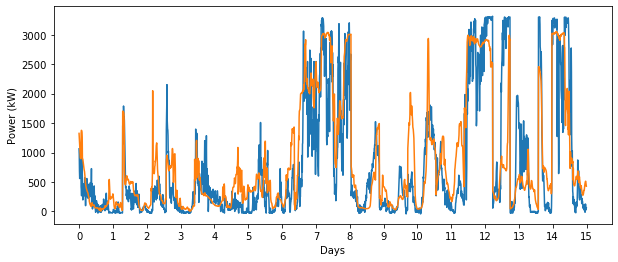

------  WTG08  ------
MAE = 11.34
RMSE = 17.02
MedAE = 6.83
ME = 82.52


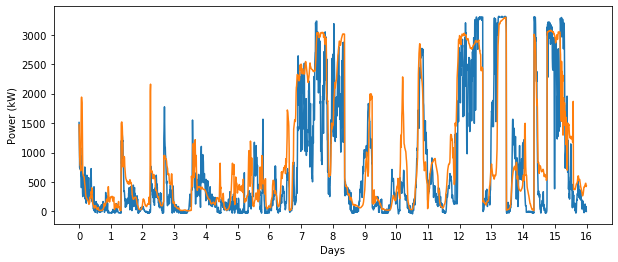

------  WTG09  ------
MAE = 10.51
RMSE = 15.81
MedAE = 6.88
ME = 80.61


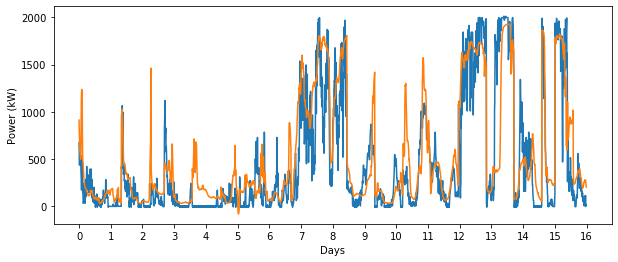

------  WTG10  ------
MAE = 11.13
RMSE = 16.6
MedAE = 6.18
ME = 80.02


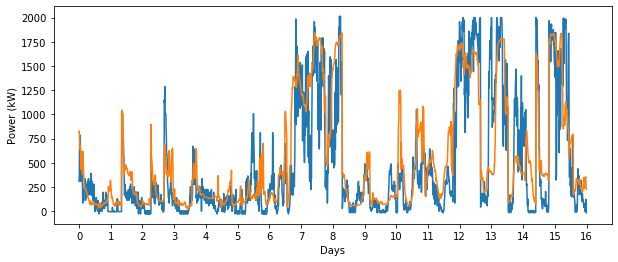

------  WTG11  ------
MAE = 11.85
RMSE = 17.8
MedAE = 6.9
ME = 86.03


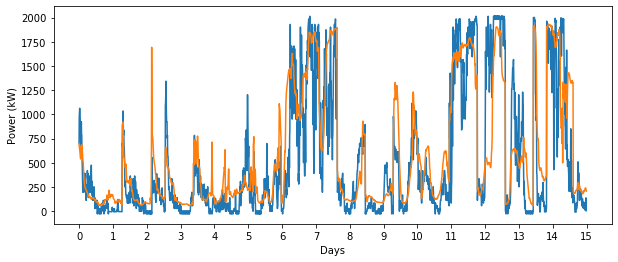

------  WTG12  ------
MAE = 11.52
RMSE = 17.98
MedAE = 6.65
ME = 87.47


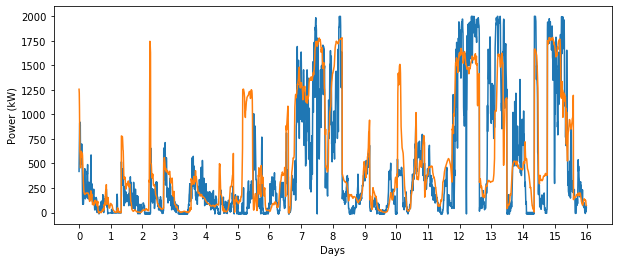

------  WTG13  ------
MAE = 11.95
RMSE = 18.2
MedAE = 7.08
ME = 102.06


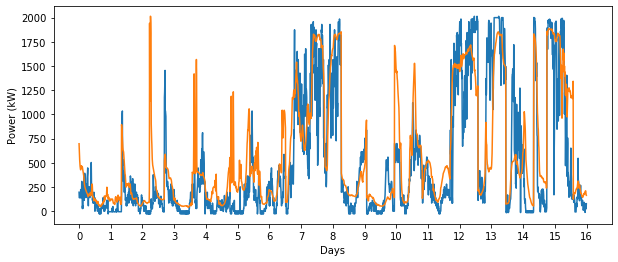

------  WTG14  ------
MAE = 12.21
RMSE = 18.34
MedAE = 7.33
ME = 82.77


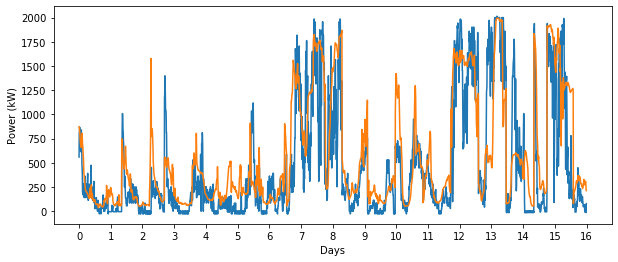

------  WTG15  ------
MAE = 12.08
RMSE = 18.78
MedAE = 6.76
ME = 80.51


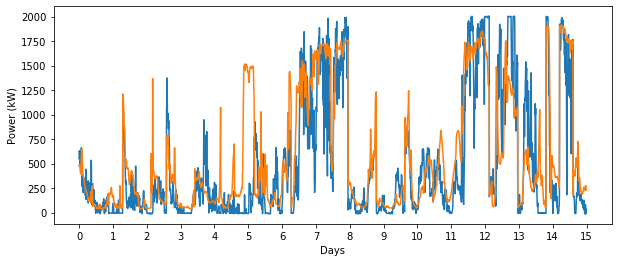

------  WTG16  ------
MAE = 12.27
RMSE = 18.69
MedAE = 6.86
ME = 74.88


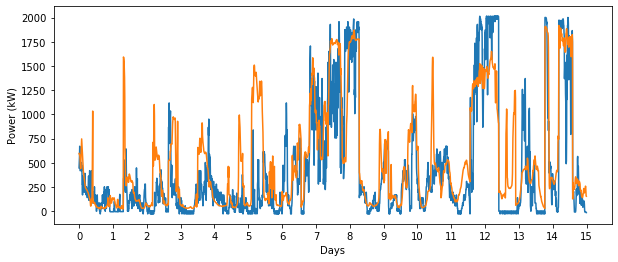

In [219]:
val_stats={}
for wt in wt_list:
    print('------  '+wt+'  ------')
    dfout = wnn_dict[wt].predict_new_data(wt_95_test[wt],wt_150_test[wt])
    stats = get_stats(dfout)
    val_stats[wt] = [stats['R2']]
    for i in list(stats.keys())[1:]:
        val_stats[wt].append(100*stats[i]/nominal_power[wt])
        print(i +' = '+ str(np.round(val_stats[wt][-1],2)))
    
    fig,ax = plt.subplots(figsize=(10,4))
    plt.plot(dfout.Power.values,label = 'Measured')
    plt.plot(dfout.Predicted_Power.values,label = 'ANN Predicted')
    
    xaux = np.arange(0,np.floor(len(dfout.Predicted_Power.values)/(24*6)))
    ax.set_xticks(np.linspace(0,len(dfout.Predicted_Power.values),len(xaux)))
    ax.set_xticklabels([int(i) for i in xaux])
    
    plt.xlabel('Days')
    plt.ylabel('Power (kW)')
    plt.show()

#### Normalize prediction statistics by the nominal power of the wind turbines

In [93]:
for wt in all_stats:  # convert stats into percentge except for R2
    tmp = all_stats[wt]
    tmp[2] = np.sqrt(tmp[2])
    all_stats[wt] = [tmp[0]] + [100*i / nominal_power[wt] for i in tmp[1:]]

In [94]:
df = pd.DataFrame(all_stats)
df_val = pd.DataFrame(val_stats)

In [116]:
def autolabel(ax,rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(np.round(height,1)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
    return ax
        
        
def bar_metrics(x1,x2,labels,ylabel,title,width = 0.35,loc = 3,figsize=(14,5)):
    fig,ax = plt.subplots(figsize=figsize)
    xx = np.arange(len(labels))  # the label locations
      # the width of the bars

    rects1 = ax.bar(xx - width/2, x1, width, label='Test Set')
    rects2 = ax.bar(xx + width/2, x2, width, label='Validation Set')
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel,fontsize = 14)
    ax.set_title(title)
    ax.set_xticks(xx)
    ax.set_xticklabels(labels)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.legend(loc = loc)
    ax = autolabel(ax,rects1)
    ax = autolabel(ax,rects2)
    plt.show()
    return fig, ax

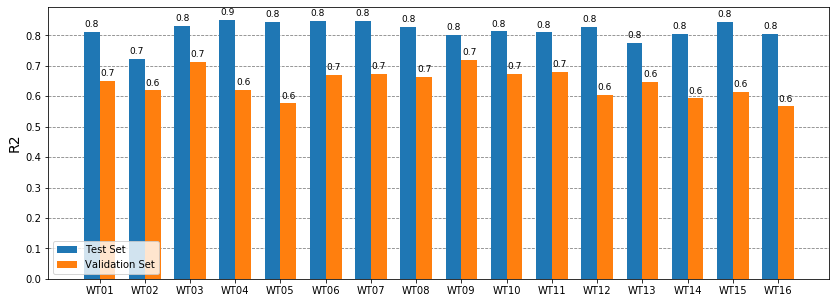

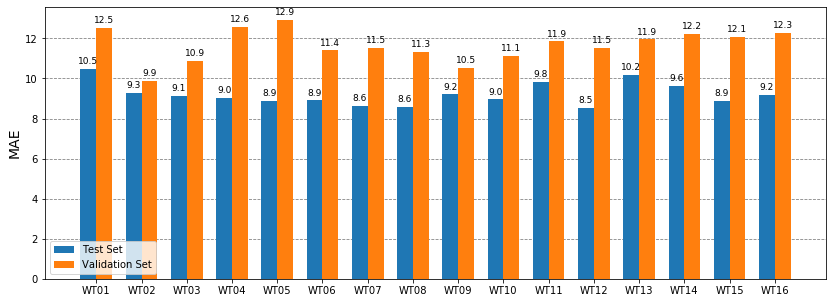

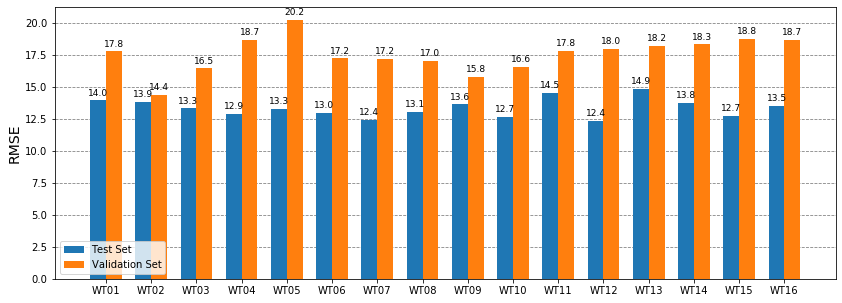

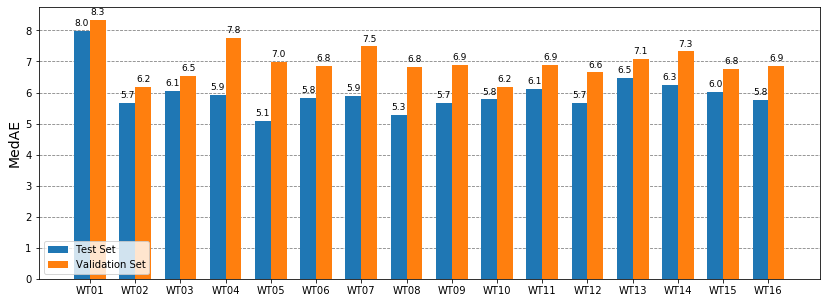

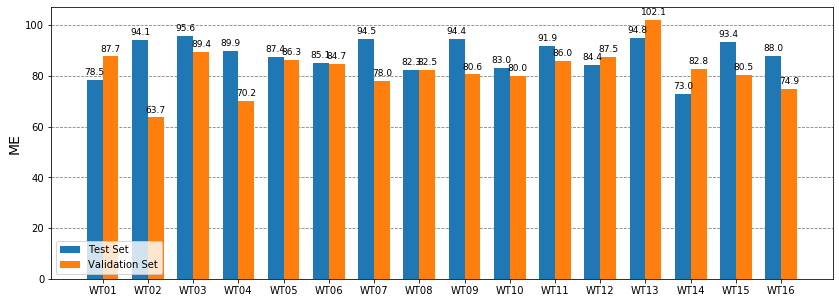

In [117]:
labels = [''.join(i.split('G')) for i in df.columns]
for i,s in enumerate(['R2', 'MAE', 'RMSE', 'MedAE', 'ME']):
    fig, ax = bar_metrics(df.iloc[i],df_val.iloc[i],labels,s,'',figsize=(14,5))
    #fig.savefig('bar_'+s+'.pdf')

#### We need to compare the performance of the direct power prediction from the ANN with a baseline model, we chose to directly predict power from the WRF wind speed, usgin a wind speed-power curve fitted with a gamma curve as baseline

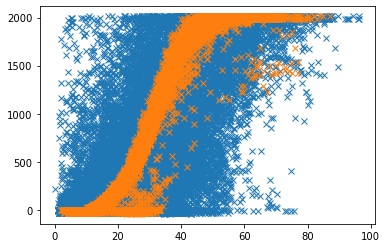

In [97]:
plt.plot(wt_95_retrain[wt]['Ws'].values*3.6,wt_95_retrain[wt]['Power'].values,'x')
plt.plot(wt_95_retrain[wt]['Wind_Speed'].values,wt_95_retrain[wt]['Power'].values,'x')

In [98]:
base1_stats={}
for wt in wt_list:
    gpc = gam(wt_95_retrain[wt]['Wind_Speed'],wt_95_retrain[wt]['Power'])
    dftmp = pd.DataFrame({'Power':wt_95_test[wt]['Power'].values,
                          'Predicted_Power':gpc(wt_95_test[wt]['Ws'].values*3.6)})
    stats = get_stats(dftmp)
    base1_stats[wt] = [stats['R2']]
    for i in list(stats.keys())[1:]:
        base1_stats[wt].append(100*stats[i]/nominal_power[wt])

In [99]:
df_base = pd.DataFrame(base1_stats)

In [110]:
def bar_metrics_3(x1,x2,x3,labels,ylabel,title,width = 0.28,loc = 3,figsize=(14,5)):
    fig,ax = plt.subplots(figsize=figsize)
    xx = np.arange(len(labels))  # the label locations
      # the width of the bars

    rects1 = ax.bar(xx - width, x1, width, label='Test Set')
    rects2 = ax.bar(xx , x2, width, label='Validation Set')
    rects3 = ax.bar(xx + width, x3, width, label='Baseline Model')
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel,fontsize = 14)
    ax.set_title(title)
    ax.set_xticks(xx)
    ax.set_xticklabels(labels)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.legend(loc = loc)
    ax = autolabel(ax,rects1)
    ax = autolabel(ax,rects2)
    ax = autolabel(ax,rects3)
    plt.show()
    return fig, ax

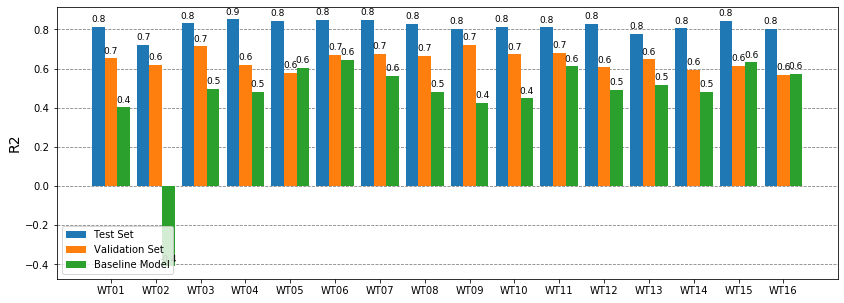

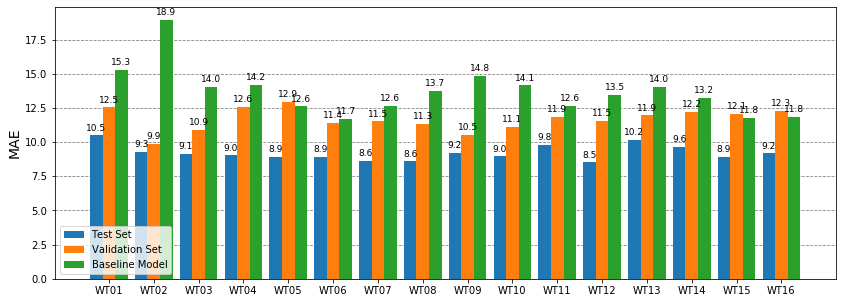

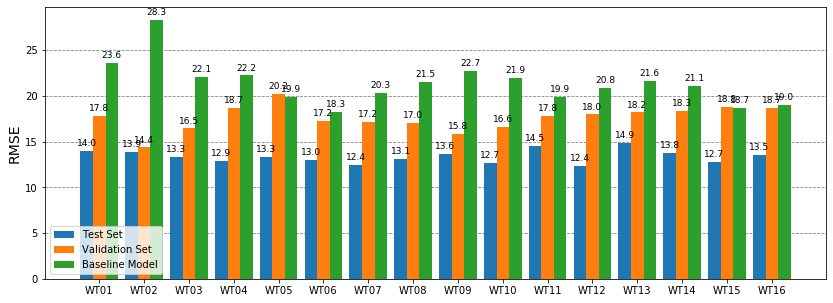

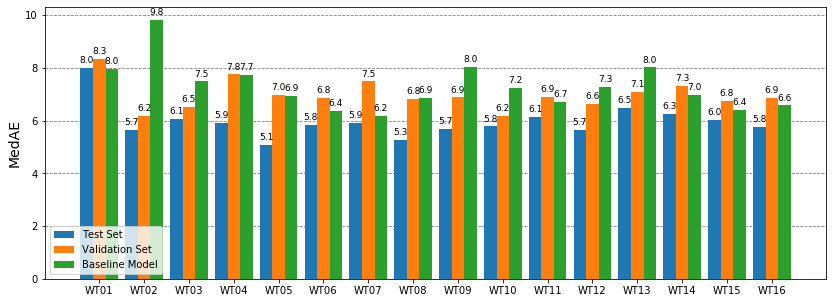

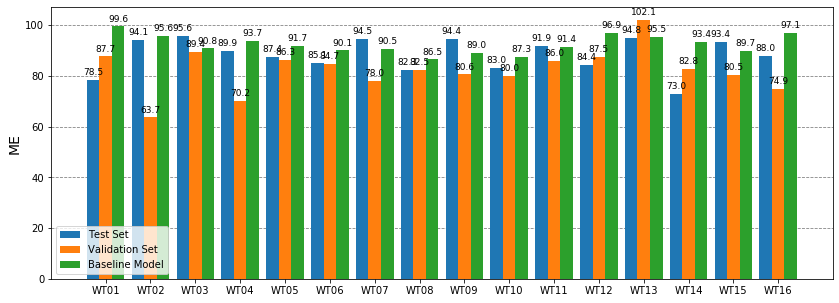

In [118]:
labels = [''.join(i.split('G')) for i in df.columns]
for i,s in enumerate(['R2', 'MAE', 'RMSE', 'MedAE', 'ME']):
    fig, ax = bar_metrics_3(df.iloc[i],df_val.iloc[i],df_base.iloc[i],labels,s,'',figsize=(14,5))
    #fig.savefig('bar_'+s+'.pdf')

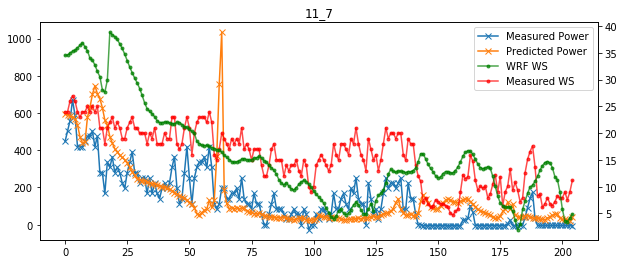

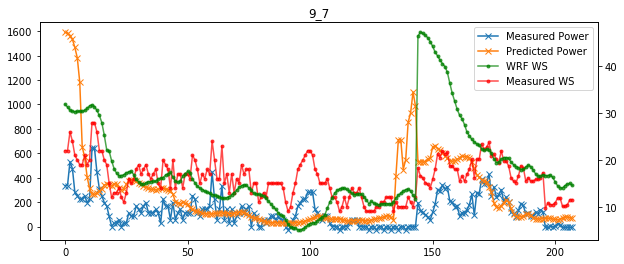

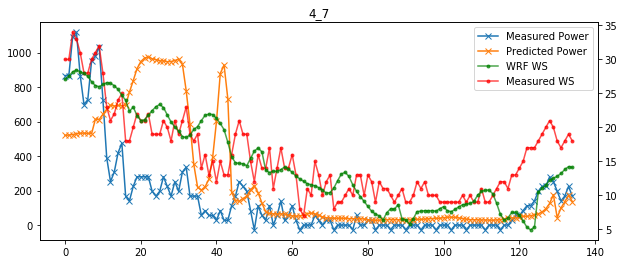

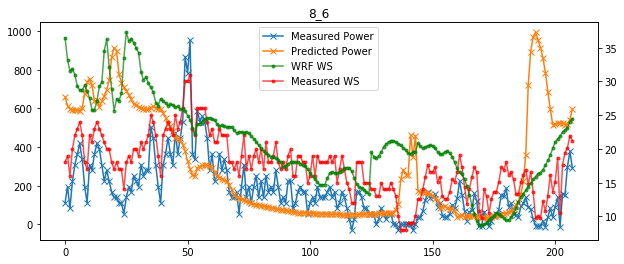

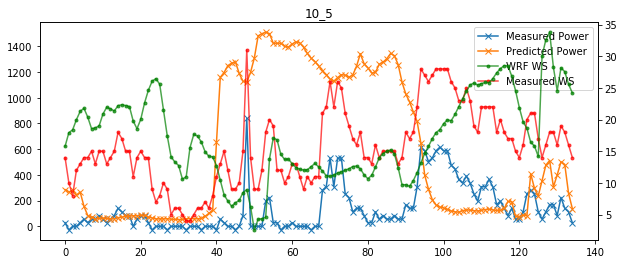

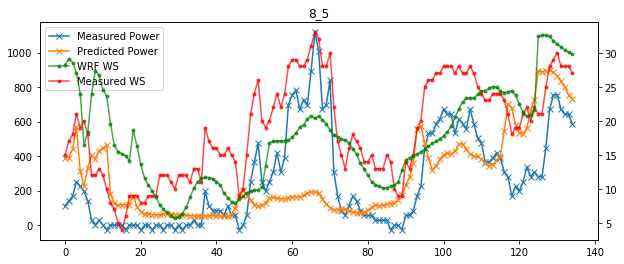

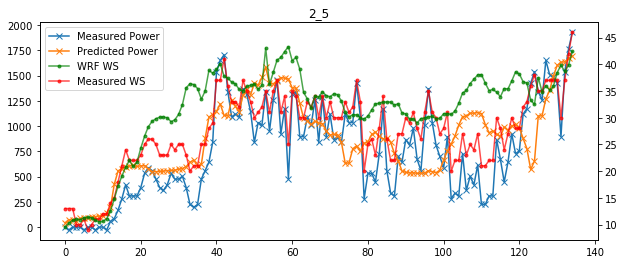

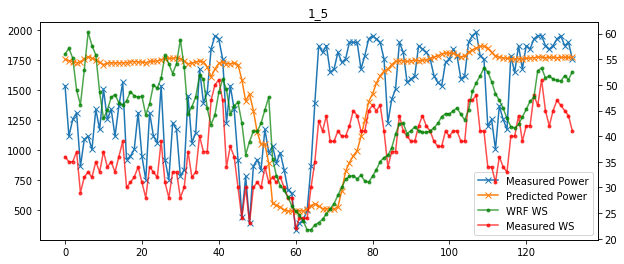

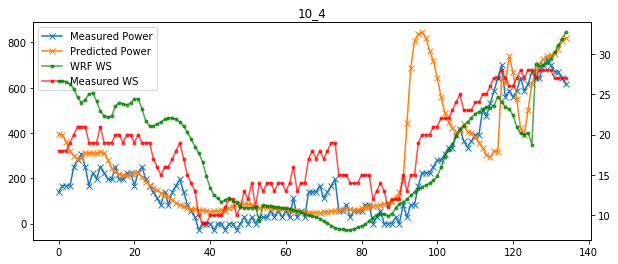

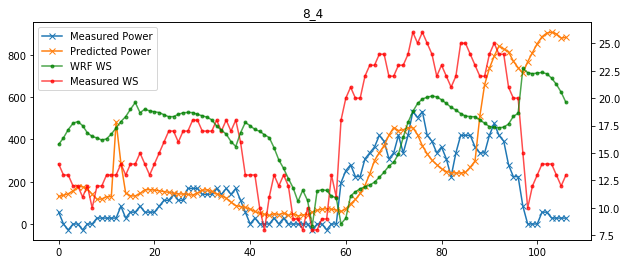

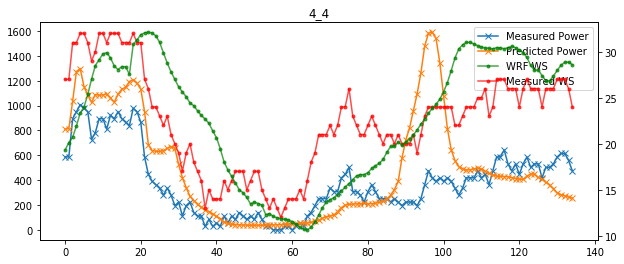

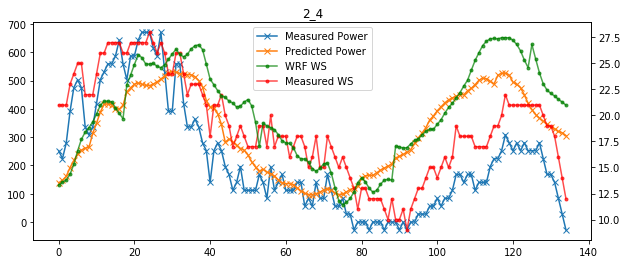

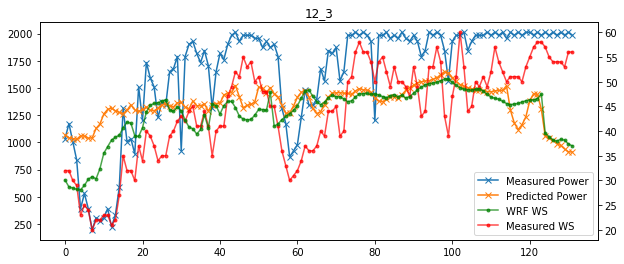

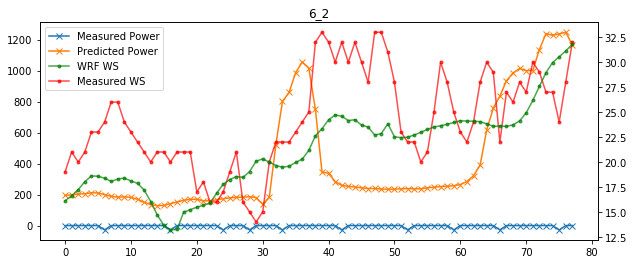

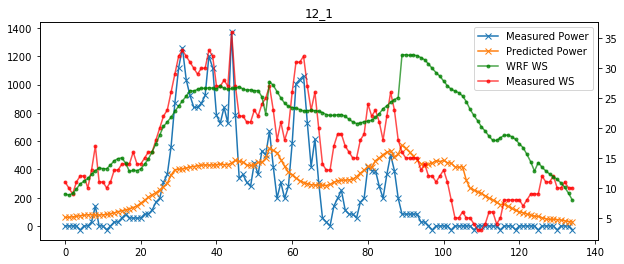

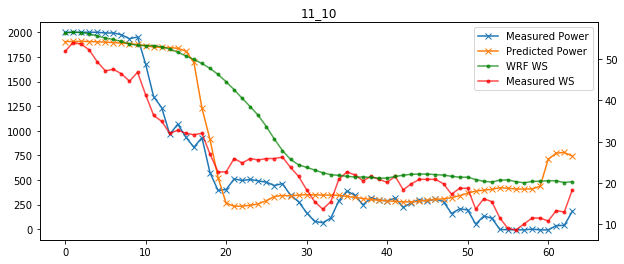

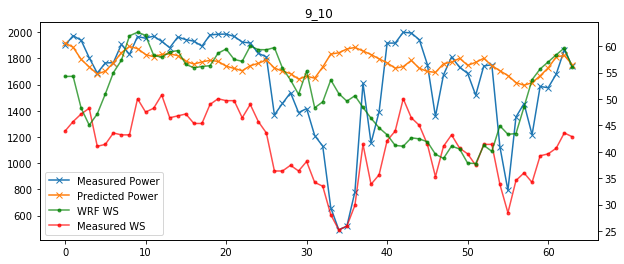

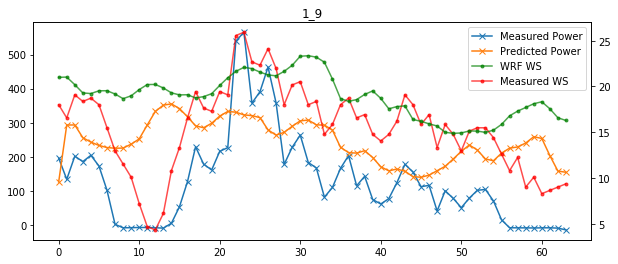

In [102]:
for dm in dfout.Day_Month.unique():
    tmp = dfout[dfout.Day_Month == dm]
    fig,ax = plt.subplots(figsize=(10,4))
    ln1 = ax.plot(tmp.Power.values,'-x',label = 'Measured Power' )
    ln2 = ax.plot(tmp.Predicted_Power.values,'-x',label = 'Predicted Power')

    ax2 = ax.twinx()
    ln4 = ax2.plot(tmp.Wind_Speed.values,'r.-',alpha = 0.7,label = 'Measured WS')
    ln3 = ax2.plot(tmp.Ws.values*3.6,'g.-',alpha = 0.7,label = 'WRF WS')
    
    
    lns = ln1+ln2+ln3+ln4
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs)
    plt.title(dm)
    plt.show()

***we can also use a Neural Network to predict wind speed and then use that wind speed to predict power via a wind speed-power curve***

In [103]:
wnn_dict_ws = {}
for wt in wt_list:
    print('----------------------')
    print('------  '+wt+'  ------')
    print('----------------------')
    wnn = WNN.WindNeuralNetwork(wt_95_retrain[wt],wt_150_retrain[wt],var = 'Wind_Speed',
                                features=['Ws', 'Wdir', 'T','P'],
                                look_back=9,
                                time_jump=1,
                                q_weight=1,
                                quantile=0.6,
                                include_tanh = True,
                                patience = 3,
                                epochs = 45,
                                scaler = 'Standard') #Initialize it with the loaded data
    wnn.prep_data()#Prepare the data
    wnn.create_and_fit_model(verbose = 1)  # Create and fit the model  you can set verbose to 1 to see the training evolution
    wnn.predict_and_getmetrics_test()
    print(wnn.stats)
    wnn_dict_ws[wt] = wnn

----------------------
------  WTG01  ------
----------------------
Train on 26259 samples, validate on 4635 samples
Epoch 1/45
26259/26259 [==============================] - 1s 43us/step - loss: 0.2710 - val_loss: 0.2350
Epoch 2/45
26259/26259 [==============================] - 1s 37us/step - loss: 0.2434 - val_loss: 0.2344
Epoch 3/45
26259/26259 [==============================] - 1s 38us/step - loss: 0.2355 - val_loss: 0.2285
Epoch 4/45
26259/26259 [==============================] - 1s 38us/step - loss: 0.2280 - val_loss: 0.2204
Epoch 5/45
26259/26259 [==============================] - 1s 37us/step - loss: 0.2243 - val_loss: 0.2201
Epoch 6/45
26259/26259 [==============================] - 1s 37us/step - loss: 0.2188 - val_loss: 0.2127
Epoch 7/45
26259/26259 [==============================] - 1s 37us/step - loss: 0.2130 - val_loss: 0.2168
Epoch 8/45
26259/26259 [==============================] - 1s 37us/step - loss: 0.2085 - val_loss: 0.2057
Epoch 9/45
26259/26259 [===================

26400/26400 [==============================] - 1s 37us/step - loss: 0.1946 - val_loss: 0.1969
Epoch 8/45
26400/26400 [==============================] - 1s 37us/step - loss: 0.1925 - val_loss: 0.1922
Epoch 9/45
26400/26400 [==============================] - 1s 37us/step - loss: 0.1900 - val_loss: 0.1926
Epoch 10/45
26400/26400 [==============================] - 1s 37us/step - loss: 0.1850 - val_loss: 0.1857
Epoch 11/45
26400/26400 [==============================] - 1s 37us/step - loss: 0.1834 - val_loss: 0.1879
Epoch 12/45
26400/26400 [==============================] - 1s 37us/step - loss: 0.1810 - val_loss: 0.1856
Epoch 13/45
26400/26400 [==============================] - 1s 37us/step - loss: 0.1786 - val_loss: 0.1783
Epoch 14/45
26400/26400 [==============================] - 1s 37us/step - loss: 0.1754 - val_loss: 0.1877
Epoch 15/45
26400/26400 [==============================] - 1s 37us/step - loss: 0.1733 - val_loss: 0.1864
Epoch 16/45
26400/26400 [==============================] - 1

26202/26202 [==============================] - 1s 38us/step - loss: 0.2262 - val_loss: 0.2433
Epoch 6/45
26202/26202 [==============================] - 1s 38us/step - loss: 0.2207 - val_loss: 0.2266
Epoch 7/45
26202/26202 [==============================] - 1s 38us/step - loss: 0.2165 - val_loss: 0.2058
Epoch 8/45
26202/26202 [==============================] - 1s 38us/step - loss: 0.2123 - val_loss: 0.2155
Epoch 9/45
26202/26202 [==============================] - 1s 38us/step - loss: 0.2062 - val_loss: 0.2065
Epoch 10/45
26202/26202 [==============================] - 1s 38us/step - loss: 0.2039 - val_loss: 0.1960
Epoch 11/45
26202/26202 [==============================] - 1s 38us/step - loss: 0.2017 - val_loss: 0.2014
Epoch 12/45
26202/26202 [==============================] - 1s 38us/step - loss: 0.1936 - val_loss: 0.2008
Epoch 13/45
26202/26202 [==============================] - 1s 38us/step - loss: 0.1923 - val_loss: 0.1808
Epoch 14/45
26202/26202 [==============================] - 1s 

26299/26299 [==============================] - 1s 36us/step - loss: 0.2116 - val_loss: 0.2224
Epoch 11/45
26299/26299 [==============================] - 1s 37us/step - loss: 0.2103 - val_loss: 0.2406
Epoch 12/45
26299/26299 [==============================] - 1s 36us/step - loss: 0.2057 - val_loss: 0.2422
Epoch 13/45
26299/26299 [==============================] - 1s 37us/step - loss: 0.2051 - val_loss: 0.2340
[0.7696110609695281, 3.9827436556378037, 27.073130195353666, 3.2132646983561823, 46.616487559604806]
----------------------
------  WTG13  ------
----------------------
Train on 25033 samples, validate on 4418 samples
Epoch 1/45
25033/25033 [==============================] - 1s 44us/step - loss: 0.2859 - val_loss: 0.2597
Epoch 2/45
25033/25033 [==============================] - 1s 37us/step - loss: 0.2590 - val_loss: 0.2475
Epoch 3/45
25033/25033 [==============================] - 1s 37us/step - loss: 0.2465 - val_loss: 0.2432
Epoch 4/45
25033/25033 [==============================]

25865/25865 [==============================] - 1s 46us/step - loss: 0.1634 - val_loss: 0.1854
Epoch 31/45
25865/25865 [==============================] - 1s 43us/step - loss: 0.1621 - val_loss: 0.1738
Epoch 32/45
25865/25865 [==============================] - 1s 45us/step - loss: 0.1621 - val_loss: 0.1775
Epoch 33/45
25865/25865 [==============================] - 1s 46us/step - loss: 0.1582 - val_loss: 0.1741
Epoch 34/45
25865/25865 [==============================] - 1s 44us/step - loss: 0.1566 - val_loss: 0.1883
[0.8322736812010436, 3.925802930592197, 25.24098199439987, 3.264941940494557, 28.05387189200818]
----------------------
------  WTG16  ------
----------------------
Train on 25176 samples, validate on 4443 samples
Epoch 1/45
25176/25176 [==============================] - 1s 45us/step - loss: 0.3105 - val_loss: 0.2582
Epoch 2/45
25176/25176 [==============================] - 1s 38us/step - loss: 0.2630 - val_loss: 0.2390
Epoch 3/45
25176/25176 [==============================] - 

In [221]:
## Save the trained models
#with open('wnn_dict_ws_final.pickle', 'wb') as handle:
#    pickle.dump(wnn_dict_ws, handle, protocol=pickle.HIGHEST_PROTOCOL)

------  WTG01  ------
MAE = 4.28
RMSE = 5.5
MedAE = 3.44
ME = 17.93


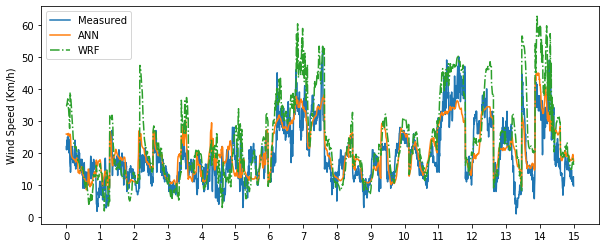

------  WTG02  ------
MAE = 4.16
RMSE = 5.28
MedAE = 3.37
ME = 19.7


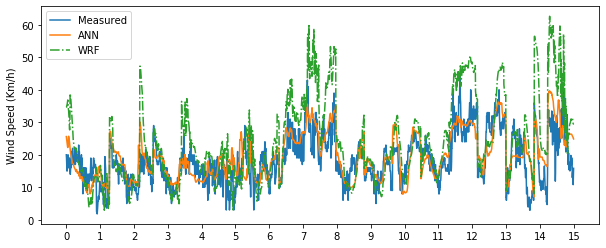

------  WTG03  ------
MAE = 4.35
RMSE = 5.72
MedAE = 3.35
ME = 22.74


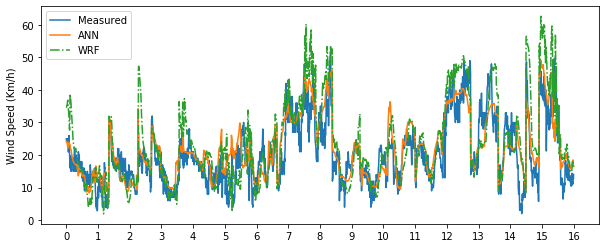

------  WTG04  ------
MAE = 4.8
RMSE = 6.37
MedAE = 3.55
ME = 26.21


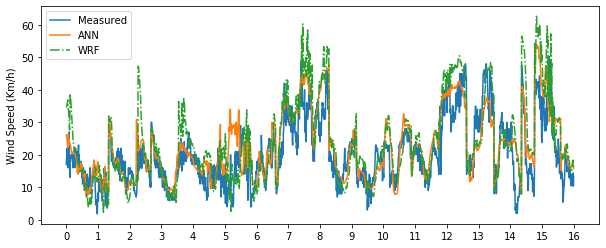

------  WTG05  ------
MAE = 5.6
RMSE = 7.8
MedAE = 4.02
ME = 35.12


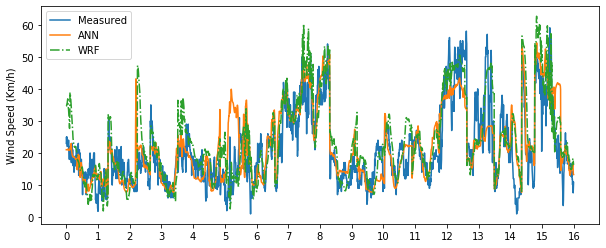

------  WTG06  ------
MAE = 5.14
RMSE = 6.92
MedAE = 3.69
ME = 33.05


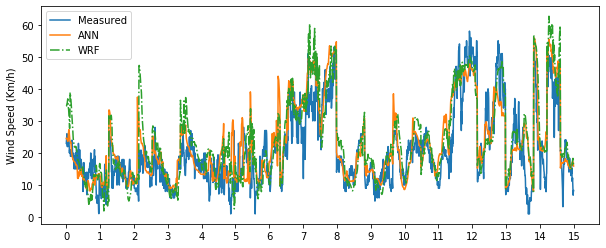

------  WTG07  ------
MAE = 4.96
RMSE = 6.33
MedAE = 4.06
ME = 28.97


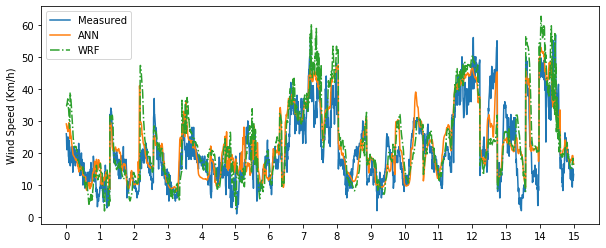

------  WTG08  ------
MAE = 4.74
RMSE = 6.45
MedAE = 3.54
ME = 35.42


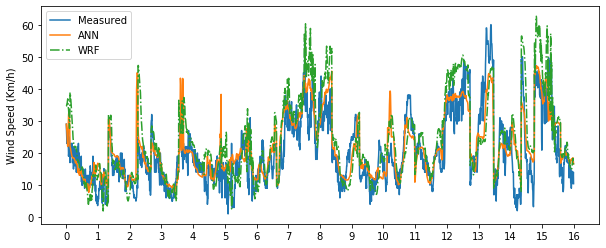

------  WTG09  ------
MAE = 4.73
RMSE = 6.21
MedAE = 3.63
ME = 25.05


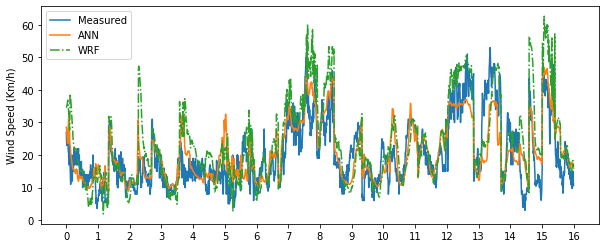

------  WTG10  ------
MAE = 4.39
RMSE = 5.67
MedAE = 3.45
ME = 20.15


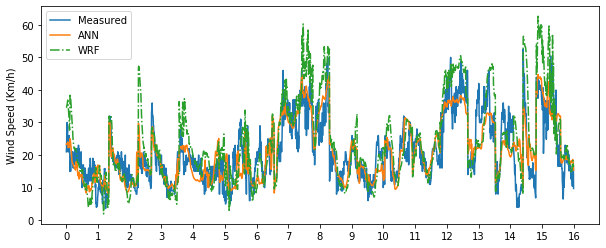

------  WTG11  ------
MAE = 5.12
RMSE = 6.73
MedAE = 3.96
ME = 26.59


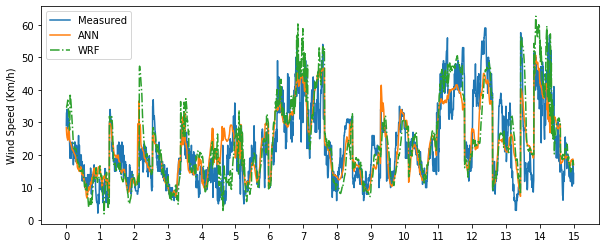

------  WTG12  ------
MAE = 4.29
RMSE = 5.58
MedAE = 3.32
ME = 22.1


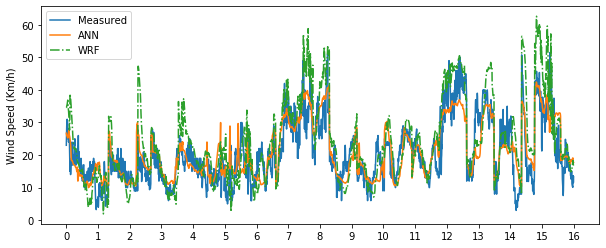

------  WTG13  ------
MAE = 4.73
RMSE = 6.41
MedAE = 3.43
ME = 26.93


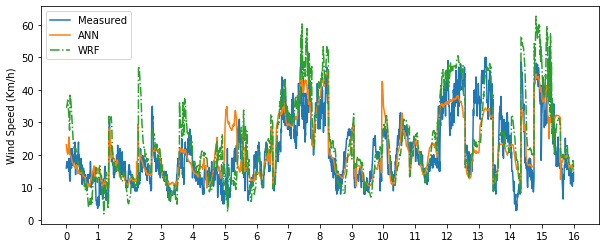

------  WTG14  ------
MAE = 5.77
RMSE = 7.76
MedAE = 4.19
ME = 34.95


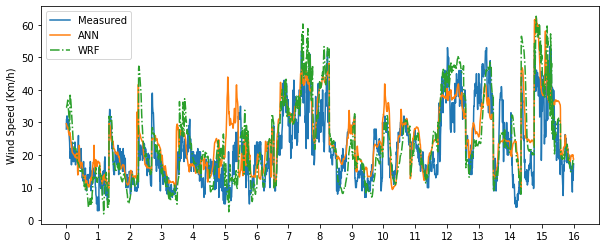

------  WTG15  ------
MAE = 5.33
RMSE = 7.03
MedAE = 4.0
ME = 26.72


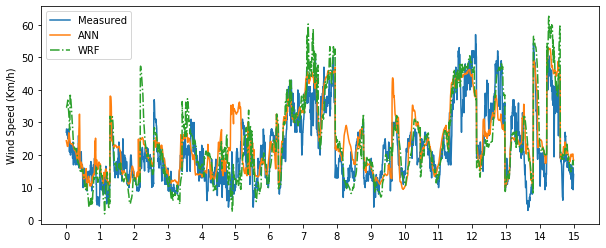

------  WTG16  ------
MAE = 5.37
RMSE = 7.27
MedAE = 3.91
ME = 35.99


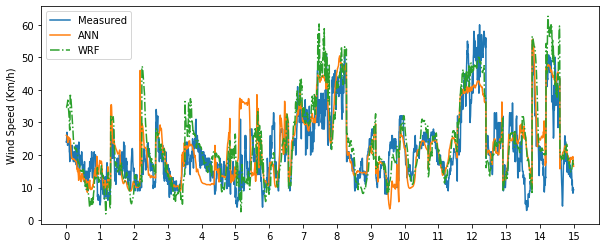

In [216]:
base2_stats={}
for wt in wt_list:
    print('------  '+wt+'  ------')
    dfout = wnn_dict_ws[wt].predict_new_data(wt_95_test[wt],wt_150_test[wt])
    stats = get_stats(dfout,t_name='Wind_Speed')
    for i in list(stats.keys())[1:]:
        print(i +' = '+ str(np.round(stats[i],2)))
    
    
    fig,ax = plt.subplots(figsize=(10,4))
    plt.plot(dfout.Wind_Speed.values,label = 'Measured')
    plt.plot(dfout.Predicted_Power.values,label = 'ANN')
    plt.plot(dfout.Ws.values*3.6,'-.',label = 'WRF')
    plt.ylabel('Wind Speed (Km/h)')
    plt.legend()
    
    xaux = np.arange(0,np.floor(len(dfout.Wind_Speed.values)/(24*6)))
    
    ax.set_xticks(np.linspace(0,len(dfout.Wind_Speed.values),len(xaux)))
    ax.set_xticklabels([int(i) for i in xaux])
    
    plt.xlabel('Days')
    
    plt.show()
    ## From the ANN wind speed interpolate power using the wind power curve
    gpc = gam(wt_95_retrain[wt]['Wind_Speed'],wt_95_retrain[wt]['Power'])
    dftmp = pd.DataFrame({'Power':dfout['Power'].values,
                          'Predicted_Power':gpc(dfout['Predicted_Power'].values)})
    stats = get_stats(dftmp)
    base2_stats[wt] = [stats['R2']]
    for i in list(stats.keys())[1:]:
        base2_stats[wt].append(100*stats[i]/nominal_power[wt])
    
    dfout['Predicted_Power'] = dftmp['Predicted_Power'].values

In [209]:
np.arange(0,np.floor(ax.get_xticks()[-1]/(24*6)))

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16.])

#### All the statistics of the four models in one dataframe

In [150]:
r2_df = df_all_stats.iloc[0::5]

WTG01     WTG02     WTG03     WTG04     WTG05     WTG06  \
R2_train  0.810828  0.722457  0.830525  0.850981  0.843518  0.848305   
R2_val    0.651228  0.619447  0.712616  0.619959  0.576524  0.671339   
R2_base   0.401063 -0.410580  0.496233  0.480415  0.601773  0.642417   
R2_wp     0.735760  0.558158  0.704608  0.635790  0.567268  0.714552   

             WTG07     WTG08     WTG09     WTG10     WTG11     WTG12  \
R2_train  0.847895  0.827714  0.801947  0.813473  0.810115  0.827086   
R2_val    0.672657  0.665001  0.718889  0.672342  0.679230  0.605415   
R2_base   0.563228  0.478799  0.425896  0.447032  0.611193  0.489972   
R2_wp     0.715491  0.656157  0.641141  0.689919  0.696607  0.702574   

             WTG13     WTG14     WTG15     WTG16  
R2_train  0.776661  0.804917  0.843265  0.803988  
R2_val    0.646994  0.592918  0.613208  0.566753  
R2_base   0.518302  0.479989  0.631683  0.572597  
R2_wp     0.613679  0.487177  0.619770  0.617862

In [155]:
df_all_stats = pd.concat([pd.DataFrame(all_stats),
           pd.DataFrame(val_stats),
           pd.DataFrame(base1_stats),
           pd.DataFrame(base2_stats)])
df_all_stats.index = ['R2_train','MAE_train','RMSE_train','MedAE_train','ME_train',
                     'R2_val','MAE_val','RMSE_val','MedAE_val','ME_val',
                     'R2_base','MAE_base','RMSE_base','MedAE_base','ME_base',
                     'R2_wp','MAE_wp','RMSE_wp','MedAE_wp','ME_wp']
r2_df = df_all_stats.iloc[0::5].T
mae_df = df_all_stats.iloc[1::5].T
rmse_df = df_all_stats.iloc[2::5].T
medae_df = df_all_stats.iloc[3::5].T
me_df = df_all_stats.iloc[4::5].T

In [177]:
def plotbar(df,ylabel,figsize=(14,5)):
    fig,ax = plt.subplots(figsize=(14,5))
    df.plot.bar(ax=ax,rot=0)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.set_ylabel('MAE (%)')
    plt.legend(loc=1)
    plt.show()
    return fig,ax

MAE_train     9.206810
MAE_val      11.659320
MAE_base     13.692148
MAE_wp       11.220375
dtype: float64


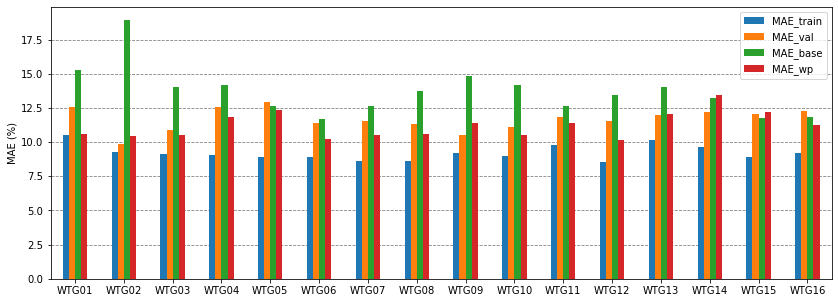

In [189]:
print(mae_df.mean())
fig,ax = plotbar(mae_df,'MAE (%)')
fig.savefig('mae_final.pdf')

RMSE_train    13.372178
RMSE_val      17.571714
RMSE_base     21.373643
RMSE_wp       17.401614
dtype: float64


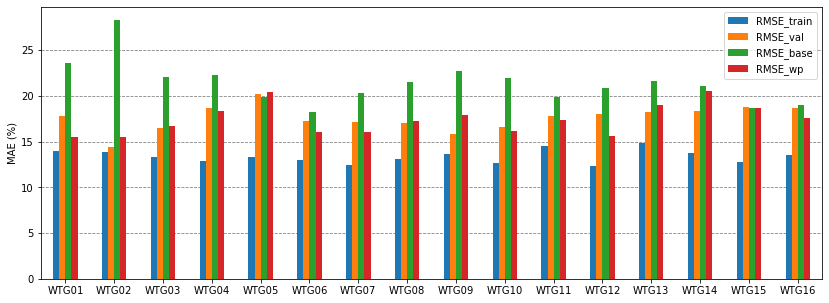

In [191]:
print(rmse_df.mean())
fig,ax = plotbar(rmse_df,'RMSE (%)')
#fig.savefig('rmse_final.pdf')

MedAE_train    5.967314
MedAE_val      6.974243
MedAE_base     7.283510
MedAE_wp       6.323819
dtype: float64


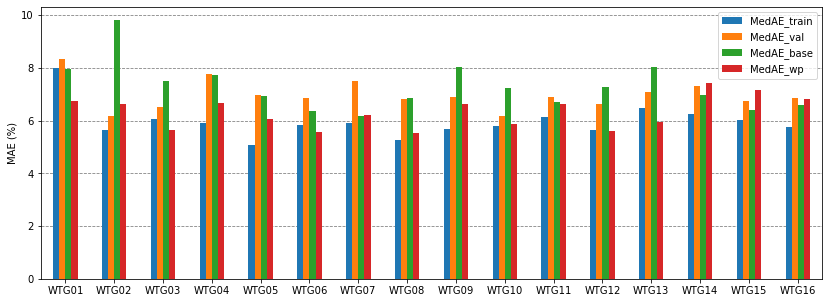

In [192]:
print(medae_df.mean())
fig,ax = plotbar(medae_df,'MedAE (%)')
#fig.savefig('medae_final.pdf')

ME_train    88.146597
ME_val      82.298192
ME_base     92.423168
ME_wp       84.112310
dtype: float64


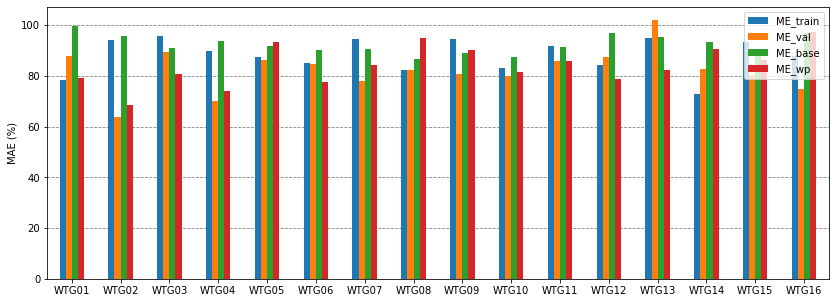

In [193]:
print(me_df.mean())
fig,ax = plotbar(me_df,'ME (%)')
#fig.savefig('me_final.pdf')